In [118]:
import yfinance as yf
from typing import List
from pandas_datareader import data as pdr
import warnings
import logging
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from docopt import docopt
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Markdown, display
import plotly.express as px

def get_financial_time_series(symbol: str, start_date: str, end_date: str,
                              type: List[str] = ('Date','Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume','LIBOR')):
    return pdr.get_data_yahoo(symbol, start=start_date, end=end_date)[type]

if __name__ == "__main__":
    start, end = "2002-01-01", "2020-01-01"
    print(get_financial_time_series("GME", start, end, ['Open', 'High', 'Low', 'Close']))
    GME_stock = get_financial_time_series("GME", start, end, ['Open', 'High', 'Low', 'Close']).reset_index()
    GME_stock['Date'] = pd.to_datetime(GME_stock['Date'])
    GME_stock.head()

              Open    High     Low   Close
Date                                      
2002-02-13   9.625  10.060   9.525  10.050
2002-02-14  10.175  10.195   9.925  10.000
2002-02-15  10.000  10.025   9.850   9.950
2002-02-19   9.900   9.900   9.375   9.550
2002-02-20   9.600   9.875   9.525   9.875
2002-02-21   9.840   9.925   9.750   9.850
2002-02-22   9.925   9.925   9.600   9.675
2002-02-25   9.650   9.825   9.540   9.750
2002-02-26   9.700   9.850   9.545   9.750
2002-02-27   9.675   9.680   9.500   9.575
2002-02-28   9.600   9.725   9.550   9.550
2002-03-01   9.525   9.775   9.490   9.685
2002-03-04   9.725   9.905   9.710   9.850
2002-03-05   9.800   9.825   9.580   9.625
2002-03-06   9.620   9.715   9.600   9.675
2002-03-07   9.675  10.300   9.675  10.210
2002-03-08  10.150  10.500  10.150  10.450
2002-03-11  10.400  10.700  10.375  10.585
2002-03-12  10.500  10.950  10.500  10.600
2002-03-13  10.600  10.750  10.325  10.510
2002-03-14  10.510  10.600  10.420  10.500
2002-03-15 

In [119]:
# compute stock return 
Pt = GME_stock.loc[:,'Close']
Pt_prev = GME_stock.loc[1:,'Close'].reset_index(drop=True)
rt = 100*(np.log(Pt[:-1]) - np.log(Pt_prev))
rt = pd.concat([pd.Series([np.nan]), rt]).reset_index(drop=True)
GME_stock['rt'] = rt
df_rt = GME_stock.dropna().reset_index(drop=True)
df_rt

Date    Open    High     Low   Close         rt
0    2002-02-14  10.175  10.195   9.925  10.000   0.498756
1    2002-02-15  10.000  10.025   9.850   9.950   0.501256
2    2002-02-19   9.900   9.900   9.375   9.550   4.103136
3    2002-02-20   9.600   9.875   9.525   9.875  -3.346514
4    2002-02-21   9.840   9.925   9.750   9.850   0.253482
5    2002-02-22   9.925   9.925   9.600   9.675   1.792624
6    2002-02-25   9.650   9.825   9.540   9.750  -0.772203
7    2002-02-26   9.700   9.850   9.545   9.750   0.000000
8    2002-02-27   9.675   9.680   9.500   9.575   1.811177
9    2002-02-28   9.600   9.725   9.550   9.550   0.261434
10   2002-03-01   9.525   9.775   9.490   9.685  -1.403717
11   2002-03-04   9.725   9.905   9.710   9.850  -1.689315
12   2002-03-05   9.800   9.825   9.580   9.625   2.310761
13   2002-03-06   9.620   9.715   9.600   9.675  -0.518138
14   2002-03-07   9.675  10.300   9.675  10.210  -5.382238
15   2002-03-08  10.150  10.500  10.150  10.450  -2.323432
16   2002-03-11  10.400  10.700  10.375  10.585  -1.283595
17   2002-03-12  10.500  10.950  10.500  10.600  -0.141613
18   2002-03-13  10.600  10.750  10.325  10.510   0.852683
19   2002-03-14  10.510  10.600  10.420  10.500   0.095195
20   2002-03-15  10.500  10.550   9.950  10.175   3.144151
21   2002-03-18  10.200  10.200   9.525   9.650   5.297587
22   2002-03-19   9.725   9.750   9.300   9.350   3.158149
23   2002-03-20   9.275   9.275   8.500   9.010   3.704129
24   2002-03-21   9.010   9.625   9.010   9.375  -3.971147
25   2002-03-22   9.375   9.795   9.255   9.650  -2.891130
26   2002-03-25   9.750   9.905   9.590   9.860  -2.152826
27   2002-03-26  10.000  10.050   9.890   9.990  -1.309844
28   2002-03-27   9.990  10.500   9.950  10.300  -3.055934
29   2002-03-28  10.250  10.300  10.050  10.100   1.960845
...         ...     ...     ...     ...     ...        ...
4471 2019-11-18   5.850   5.850   5.610   5.620   4.522514
4472 2019-11-19   5.570   5.660   5.450   5.500   2.158355
4473 2019-11-20   5.540   5.540   5.360   5.460   0.729930
4474 2019-11-21   5.460   5.580   5.350   5.500  -0.729930
4475 2019-11-22   5.590   5.850   5.500   5.660  -2.867577
4476 2019-11-25   5.670   6.060   5.630   6.030  -6.332318
4477 2019-11-26   6.030   6.260   6.010   6.100  -1.154171
4478 2019-11-27   6.100   6.390   6.020   6.350  -4.016604
4479 2019-11-29   6.330   6.390   6.240   6.340   0.157601
4480 2019-12-02   6.350   6.460   6.090   6.170   2.717994
4481 2019-12-03   6.040   6.180   5.930   6.120   0.813677
4482 2019-12-04   6.170   6.490   6.120   6.430  -4.941243
4483 2019-12-05   6.320   6.520   6.240   6.400   0.467651
4484 2019-12-06   6.390   6.680   6.390   6.680  -4.281996
4485 2019-12-09   6.650   6.920   6.190   6.330   5.381774
4486 2019-12-10   6.290   6.540   6.120   6.510  -2.803927
4487 2019-12-11   5.250   5.810   5.180   5.530  16.315164
4488 2019-12-12   5.460   5.710   5.410   5.580  -0.900091
4489 2019-12-13   5.470   5.620   5.240   5.450   2.357319
4490 2019-12-16   5.390   5.590   5.390   5.500  -0.913252
4491 2019-12-17   5.500   6.080   5.490   6.060  -9.696170
4492 2019-12-18   6.060   6.270   5.930   6.160  -1.636696
4493 2019-12-19   6.210   6.240   6.030   6.060   1.636696
4494 2019-12-20   6.060   6.220   5.960   5.990   1.161842
4495 2019-12-23   6.050   6.070   5.540   5.610   6.554063
4496 2019-12-24   5.650   5.670   5.440   5.440   3.077167
4497 2019-12-26   5.470   5.510   5.250   5.400   0.738010
4498 2019-12-27   5.420   5.980   5.390   5.900  -8.855340
4499 2019-12-30   5.880   6.250   5.760   6.130  -3.824240
4500 2019-12-31   6.080   6.390   5.990   6.080   0.819009

[4501 rows x 6 columns]

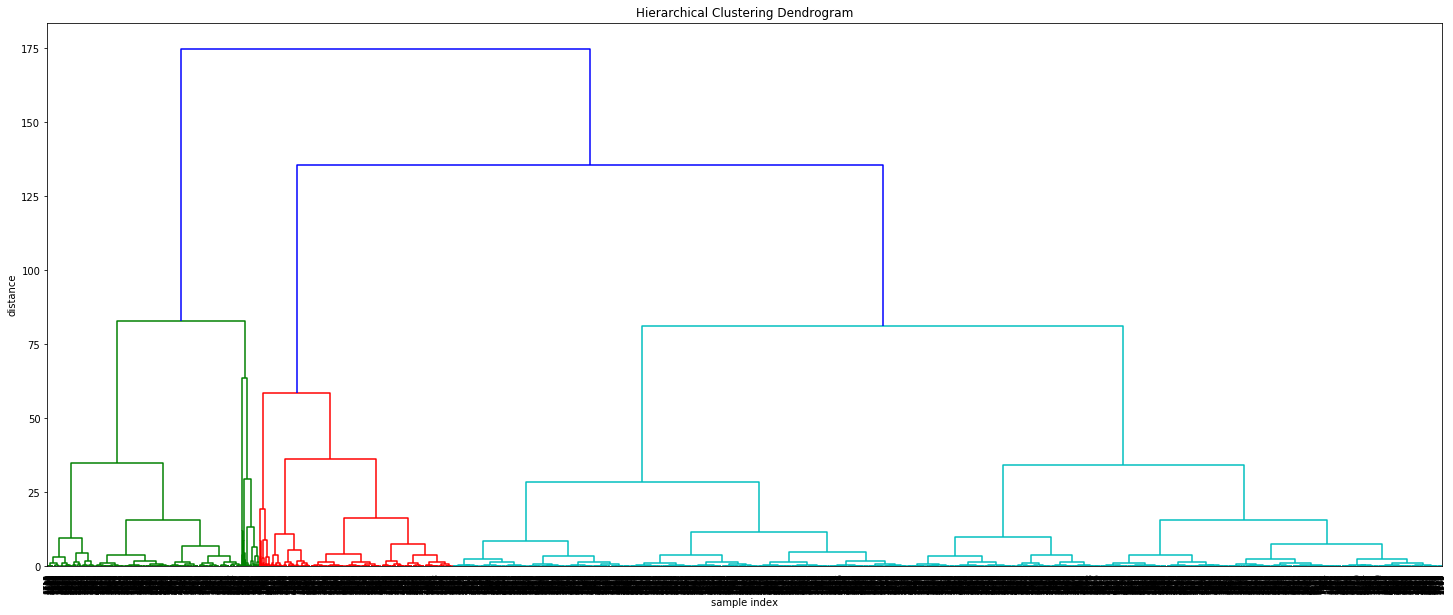

In [120]:
from scipy.cluster import hierarchy as hac

Y = df_rt.loc[:,'rt'].values
Z = hac.linkage(np.reshape(Y, (len(Y), 1)), method='ward', metric='euclidean')

# Plot dendogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [132]:
from sklearn.mixture import GaussianMixture as GMM
import plotly.graph_objects as go

Y = df_rt['rt'].values.reshape(-1,1)

L= np.arange(1,100,1)
clfs= [GMM(n,covariance_type='full').fit(Y) for n in L]
aics= [clf.aic(Y) for clf in clfs]
bics= [clf.bic(Y) for clf in clfs]
sum_ =[sum(i) for i in zip(aics, bics)]

fig = go.Figure()
fig.add_trace(go.Scatter(x=L, y=aics,
                      mode='lines+markers',
                    name='AIC'))

fig.add_trace(go.Scatter(x=L, y=bics,
                    mode='lines+markers',
                    name='BIC'))
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=L, y=sum_,
                    mode='lines+markers',
                    name='AIC+BIC'))
fig.show()

In [137]:
L = 4

Y = df_rt['rt'].values.reshape(-1,1)
GMM_cluster = GMM(L,covariance_type='full').fit(Y)
df_rt['cls'] = GMM_cluster.predict(Y)
df = px.data.iris()
fig = px.scatter(df_rt, x="Date", y="rt", color="cls", hover_data=df_rt.columns.to_list())
fig.show()

In [123]:
fig = px.scatter(df_rt, x="Date", y="Close", color="cls", hover_data=df_rt.columns.to_list())
fig.show()

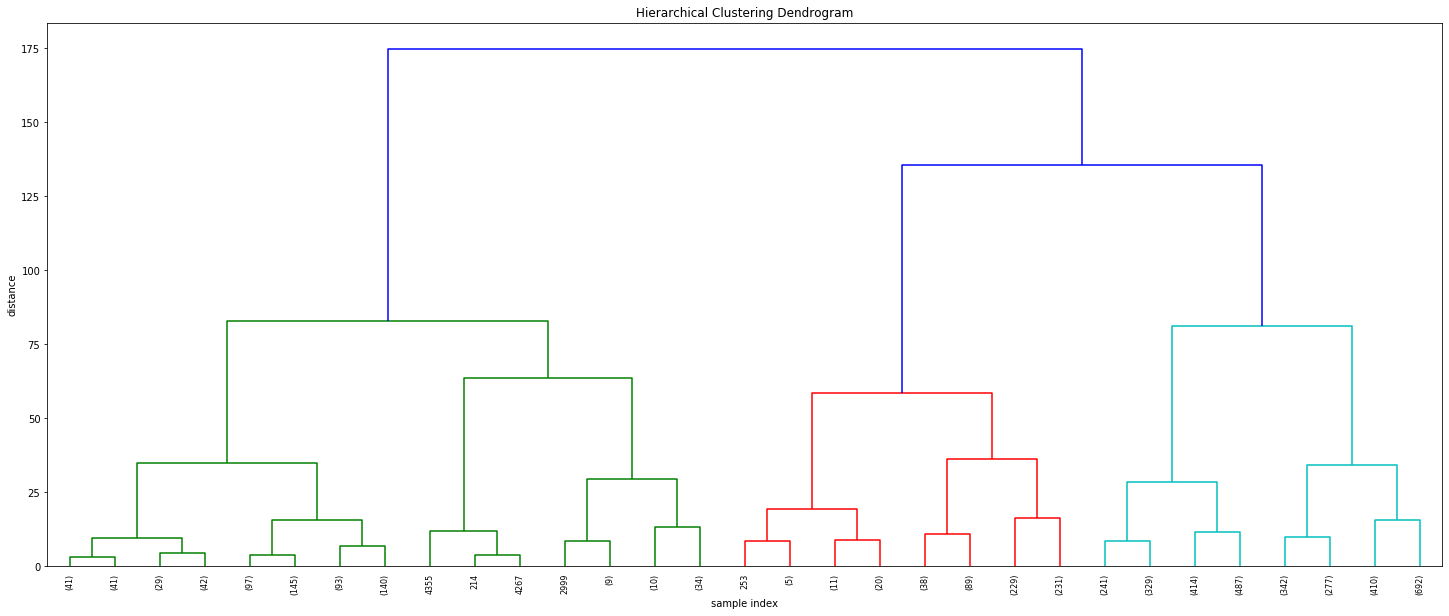

In [124]:
### from scipy.cluster import hierarchy as hac

Y = df_rt.loc[:,'rt'].values
Z = hac.linkage(np.reshape(Y, (len(Y), 1)), method='ward', metric='euclidean')

# Plot dendogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    truncate_mode='level', p=L
)
plt.show()

In [144]:
Z

array([[1.04100000e+03, 2.49900000e+03, 0.00000000e+00, 2.00000000e+00],
       [7.00000000e+00, 4.30000000e+01, 0.00000000e+00, 2.00000000e+00],
       [7.70000000e+01, 4.50200000e+03, 0.00000000e+00, 3.00000000e+00],
       ...,
       [8.99300000e+03, 8.99600000e+03, 8.29687149e+01, 6.85000000e+02],
       [8.99500000e+03, 8.99700000e+03, 1.35585434e+02, 3.81600000e+03],
       [8.99800000e+03, 8.99900000e+03, 1.74897055e+02, 4.50100000e+03]])

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [25.0, 25.0, 35.0, 35.0],
  [10.0, 10.0, 30.0, 30.0],
  [45.0, 45.0, 55.0, 55.0],
  [65.0, 65.0, 75.0, 75.0],
  [50.0, 50.0, 70.0, 70.0],
  [20.0, 20.0, 60.0, 60.0],
  [95.0, 95.0, 105.0, 105.0],
  [85.0, 85.0, 100.0, 100.0],
  [115.0, 115.0, 125.0, 125.0],
  [135.0, 135.0, 145.0, 145.0],
  [120.0, 120.0, 140.0, 140.0],
  [92.5, 92.5, 130.0, 130.0],
  [40.0, 40.0, 111.25, 111.25],
  [155.0, 155.0, 165.0, 165.0],
  [175.0, 175.0, 185.0, 185.0],
  [160.0, 160.0, 180.0, 180.0],
  [195.0, 195.0, 205.0, 205.0],
  [215.0, 215.0, 225.0, 225.0],
  [200.0, 200.0, 220.0, 220.0],
  [170.0, 170.0, 210.0, 210.0],
  [235.0, 235.0, 245.0, 245.0],
  [255.0, 255.0, 265.0, 265.0],
  [240.0, 240.0, 260.0, 260.0],
  [275.0, 275.0, 285.0, 285.0],
  [295.0, 295.0, 305.0, 305.0],
  [280.0, 280.0, 300.0, 300.0],
  [250.0, 250.0, 290.0, 290.0],
  [190.0, 190.0, 270.0, 270.0],
  [75.625, 75.625, 230.0, 230.0]],
 'dcoord': [[0.0, 3.005612723762196, 3.005612723762196, 0.0],
 

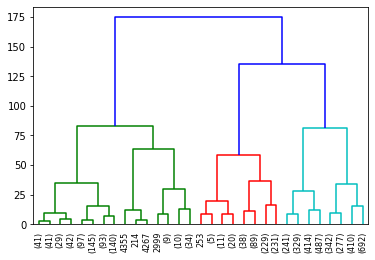

In [143]:
hac.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    truncate_mode='level', p=4
)

In [125]:
df_rt

Date    Open    High     Low   Close         rt  cls
0    2002-02-14  10.175  10.195   9.925  10.000   0.498756    0
1    2002-02-15  10.000  10.025   9.850   9.950   0.501256    0
2    2002-02-19   9.900   9.900   9.375   9.550   4.103136    1
3    2002-02-20   9.600   9.875   9.525   9.875  -3.346514    2
4    2002-02-21   9.840   9.925   9.750   9.850   0.253482    0
5    2002-02-22   9.925   9.925   9.600   9.675   1.792624    0
6    2002-02-25   9.650   9.825   9.540   9.750  -0.772203    0
7    2002-02-26   9.700   9.850   9.545   9.750   0.000000    0
8    2002-02-27   9.675   9.680   9.500   9.575   1.811177    0
9    2002-02-28   9.600   9.725   9.550   9.550   0.261434    0
10   2002-03-01   9.525   9.775   9.490   9.685  -1.403717    0
11   2002-03-04   9.725   9.905   9.710   9.850  -1.689315    0
12   2002-03-05   9.800   9.825   9.580   9.625   2.310761    1
13   2002-03-06   9.620   9.715   9.600   9.675  -0.518138    0
14   2002-03-07   9.675  10.300   9.675  10.210  -5.382238    2
15   2002-03-08  10.150  10.500  10.150  10.450  -2.323432    0
16   2002-03-11  10.400  10.700  10.375  10.585  -1.283595    0
17   2002-03-12  10.500  10.950  10.500  10.600  -0.141613    0
18   2002-03-13  10.600  10.750  10.325  10.510   0.852683    0
19   2002-03-14  10.510  10.600  10.420  10.500   0.095195    0
20   2002-03-15  10.500  10.550   9.950  10.175   3.144151    1
21   2002-03-18  10.200  10.200   9.525   9.650   5.297587    1
22   2002-03-19   9.725   9.750   9.300   9.350   3.158149    1
23   2002-03-20   9.275   9.275   8.500   9.010   3.704129    1
24   2002-03-21   9.010   9.625   9.010   9.375  -3.971147    2
25   2002-03-22   9.375   9.795   9.255   9.650  -2.891130    0
26   2002-03-25   9.750   9.905   9.590   9.860  -2.152826    0
27   2002-03-26  10.000  10.050   9.890   9.990  -1.309844    0
28   2002-03-27   9.990  10.500   9.950  10.300  -3.055934    2
29   2002-03-28  10.250  10.300  10.050  10.100   1.960845    1
...         ...     ...     ...     ...     ...        ...  ...
4471 2019-11-18   5.850   5.850   5.610   5.620   4.522514    1
4472 2019-11-19   5.570   5.660   5.450   5.500   2.158355    1
4473 2019-11-20   5.540   5.540   5.360   5.460   0.729930    0
4474 2019-11-21   5.460   5.580   5.350   5.500  -0.729930    0
4475 2019-11-22   5.590   5.850   5.500   5.660  -2.867577    0
4476 2019-11-25   5.670   6.060   5.630   6.030  -6.332318    2
4477 2019-11-26   6.030   6.260   6.010   6.100  -1.154171    0
4478 2019-11-27   6.100   6.390   6.020   6.350  -4.016604    2
4479 2019-11-29   6.330   6.390   6.240   6.340   0.157601    0
4480 2019-12-02   6.350   6.460   6.090   6.170   2.717994    1
4481 2019-12-03   6.040   6.180   5.930   6.120   0.813677    0
4482 2019-12-04   6.170   6.490   6.120   6.430  -4.941243    2
4483 2019-12-05   6.320   6.520   6.240   6.400   0.467651    0
4484 2019-12-06   6.390   6.680   6.390   6.680  -4.281996    2
4485 2019-12-09   6.650   6.920   6.190   6.330   5.381774    1
4486 2019-12-10   6.290   6.540   6.120   6.510  -2.803927    0
4487 2019-12-11   5.250   5.810   5.180   5.530  16.315164    3
4488 2019-12-12   5.460   5.710   5.410   5.580  -0.900091    0
4489 2019-12-13   5.470   5.620   5.240   5.450   2.357319    1
4490 2019-12-16   5.390   5.590   5.390   5.500  -0.913252    0
4491 2019-12-17   5.500   6.080   5.490   6.060  -9.696170    3
4492 2019-12-18   6.060   6.270   5.930   6.160  -1.636696    0
4493 2019-12-19   6.210   6.240   6.030   6.060   1.636696    0
4494 2019-12-20   6.060   6.220   5.960   5.990   1.161842    0
4495 2019-12-23   6.050   6.070   5.540   5.610   6.554063    1
4496 2019-12-24   5.650   5.670   5.440   5.440   3.077167    1
4497 2019-12-26   5.470   5.510   5.250   5.400   0.738010    0
4498 2019-12-27   5.420   5.980   5.390   5.900  -8.855340    3
4499 2019-12-30   5.880   6.250   5.760   6.130  -3.824240    2
4500 2019-12-31   6.080   6.390   5.990   6.080   0.819009    0

[4501 rows x 7 columns]

In [126]:
result_dict = df_rt.groupby('cls').agg({'rt': [np.min,np.max,np.mean]}).to_dict()
df_rt.loc[:, 'rt_cls_mean'] = df_rt['cls'].map(result_dict[('rt', 'mean')])
df_rt

Date    Open    High     Low   Close         rt  cls  rt_cls_mean
0    2002-02-14  10.175  10.195   9.925  10.000   0.498756    0    -0.346907
1    2002-02-15  10.000  10.025   9.850   9.950   0.501256    0    -0.346907
2    2002-02-19   9.900   9.900   9.375   9.550   4.103136    1     3.428766
3    2002-02-20   9.600   9.875   9.525   9.875  -3.346514    2    -4.509220
4    2002-02-21   9.840   9.925   9.750   9.850   0.253482    0    -0.346907
5    2002-02-22   9.925   9.925   9.600   9.675   1.792624    0    -0.346907
6    2002-02-25   9.650   9.825   9.540   9.750  -0.772203    0    -0.346907
7    2002-02-26   9.700   9.850   9.545   9.750   0.000000    0    -0.346907
8    2002-02-27   9.675   9.680   9.500   9.575   1.811177    0    -0.346907
9    2002-02-28   9.600   9.725   9.550   9.550   0.261434    0    -0.346907
10   2002-03-01   9.525   9.775   9.490   9.685  -1.403717    0    -0.346907
11   2002-03-04   9.725   9.905   9.710   9.850  -1.689315    0    -0.346907
12   2002-03-05   9.800   9.825   9.580   9.625   2.310761    1     3.428766
13   2002-03-06   9.620   9.715   9.600   9.675  -0.518138    0    -0.346907
14   2002-03-07   9.675  10.300   9.675  10.210  -5.382238    2    -4.509220
15   2002-03-08  10.150  10.500  10.150  10.450  -2.323432    0    -0.346907
16   2002-03-11  10.400  10.700  10.375  10.585  -1.283595    0    -0.346907
17   2002-03-12  10.500  10.950  10.500  10.600  -0.141613    0    -0.346907
18   2002-03-13  10.600  10.750  10.325  10.510   0.852683    0    -0.346907
19   2002-03-14  10.510  10.600  10.420  10.500   0.095195    0    -0.346907
20   2002-03-15  10.500  10.550   9.950  10.175   3.144151    1     3.428766
21   2002-03-18  10.200  10.200   9.525   9.650   5.297587    1     3.428766
22   2002-03-19   9.725   9.750   9.300   9.350   3.158149    1     3.428766
23   2002-03-20   9.275   9.275   8.500   9.010   3.704129    1     3.428766
24   2002-03-21   9.010   9.625   9.010   9.375  -3.971147    2    -4.509220
25   2002-03-22   9.375   9.795   9.255   9.650  -2.891130    0    -0.346907
26   2002-03-25   9.750   9.905   9.590   9.860  -2.152826    0    -0.346907
27   2002-03-26  10.000  10.050   9.890   9.990  -1.309844    0    -0.346907
28   2002-03-27   9.990  10.500   9.950  10.300  -3.055934    2    -4.509220
29   2002-03-28  10.250  10.300  10.050  10.100   1.960845    1     3.428766
...         ...     ...     ...     ...     ...        ...  ...          ...
4471 2019-11-18   5.850   5.850   5.610   5.620   4.522514    1     3.428766
4472 2019-11-19   5.570   5.660   5.450   5.500   2.158355    1     3.428766
4473 2019-11-20   5.540   5.540   5.360   5.460   0.729930    0    -0.346907
4474 2019-11-21   5.460   5.580   5.350   5.500  -0.729930    0    -0.346907
4475 2019-11-22   5.590   5.850   5.500   5.660  -2.867577    0    -0.346907
4476 2019-11-25   5.670   6.060   5.630   6.030  -6.332318    2    -4.509220
4477 2019-11-26   6.030   6.260   6.010   6.100  -1.154171    0    -0.346907
4478 2019-11-27   6.100   6.390   6.020   6.350  -4.016604    2    -4.509220
4479 2019-11-29   6.330   6.390   6.240   6.340   0.157601    0    -0.346907
4480 2019-12-02   6.350   6.460   6.090   6.170   2.717994    1     3.428766
4481 2019-12-03   6.040   6.180   5.930   6.120   0.813677    0    -0.346907
4482 2019-12-04   6.170   6.490   6.120   6.430  -4.941243    2    -4.509220
4483 2019-12-05   6.320   6.520   6.240   6.400   0.467651    0    -0.346907
4484 2019-12-06   6.390   6.680   6.390   6.680  -4.281996    2    -4.509220
4485 2019-12-09   6.650   6.920   6.190   6.330   5.381774    1     3.428766
4486 2019-12-10   6.290   6.540   6.120   6.510  -2.803927    0    -0.346907
4487 2019-12-11   5.250   5.810   5.180   5.530  16.315164    3     3.326688
4488 2019-12-12   5.460   5.710   5.410   5.580  -0.900091    0    -0.346907
4489 2019-12-13   5.470   5.620   5.240   5.450   2.357319    1     3.428766
4490 2019-12-16   5.390   5.590   5.390   5.500  -0.913252    0    -0.346907
4491 20

In [139]:
ls = []

def test(x):
    ls.append(x)
    print(x)
    return x[-1]

windows = 10
df_rt.loc[:,['rt_cls_mean']].rolling(window=windows,
                               center=False).apply(test,raw=True)

# np.array(ls)
columns = [f'r_{i}' for i in range(windows)]
df = pd.DataFrame(np.array(ls), columns=columns)
df

[-0.34690702 -0.34690702  3.42876601 -4.50922011 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702  3.42876601 -4.50922011 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[ 3.42876601 -4.50922011 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-4.50922011 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702  3.42876601]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702  3.42876601 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702  3.42876601 -0.34690702 -4.50922011]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
  3.42876601 -0.34690702 -4.50922011 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601
 -0.34690702 -4.50922011 -0.34690702 -0.34690702]
[-0.34690702 -0.

 -0.34690702 -4.50922011  3.42876601 -0.34690702]
[-4.50922011 -4.50922011 -4.50922011 -4.50922011  3.42876601 -0.34690702
 -4.50922011  3.42876601 -0.34690702 -0.34690702]
[-4.50922011 -4.50922011 -4.50922011  3.42876601 -0.34690702 -4.50922011
  3.42876601 -0.34690702 -0.34690702 -0.34690702]
[-4.50922011 -4.50922011  3.42876601 -0.34690702 -4.50922011  3.42876601
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-4.50922011  3.42876601 -0.34690702 -4.50922011  3.42876601 -0.34690702
 -0.34690702 -0.34690702 -0.34690702  3.42876601]
[ 3.42876601 -0.34690702 -4.50922011  3.42876601 -0.34690702 -0.34690702
 -0.34690702 -0.34690702  3.42876601 -0.34690702]
[-0.34690702 -4.50922011  3.42876601 -0.34690702 -0.34690702 -0.34690702
 -0.34690702  3.42876601 -0.34690702 -0.34690702]
[-4.50922011  3.42876601 -0.34690702 -0.34690702 -0.34690702 -0.34690702
  3.42876601 -0.34690702 -0.34690702 -0.34690702]
[ 3.42876601 -0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601
 -0.34690702 -0.

  3.42876601 -4.50922011 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702  3.42876601  3.42876601  3.42876601
 -4.50922011 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702  3.42876601  3.42876601  3.42876601 -4.50922011
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702  3.42876601  3.42876601  3.42876601 -4.50922011 -0.34690702
 -0.34690702 -0.34690702 -0.34690702  3.42876601]
[ 3.42876601  3.42876601  3.42876601 -4.50922011 -0.34690702 -0.34690702
 -0.34690702 -0.34690702  3.42876601  3.42876601]
[ 3.42876601  3.42876601 -4.50922011 -0.34690702 -0.34690702 -0.34690702
 -0.34690702  3.42876601  3.42876601 -4.50922011]
[ 3.42876601 -4.50922011 -0.34690702 -0.34690702 -0.34690702 -0.34690702
  3.42876601  3.42876601 -4.50922011 -0.34690702]
[-4.50922011 -0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601
  3.42876601 -4.50922011 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601  3.42876601
 -4.50922011 -0.

  3.42876601 -0.34690702  3.42876601 -4.50922011]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601
 -0.34690702  3.42876601 -4.50922011  3.32668778]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601 -0.34690702
  3.42876601 -4.50922011  3.32668778 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702  3.42876601 -0.34690702  3.42876601
 -4.50922011  3.32668778 -0.34690702  3.42876601]
[-0.34690702 -0.34690702  3.42876601 -0.34690702  3.42876601 -4.50922011
  3.32668778 -0.34690702  3.42876601  3.32668778]
[-0.34690702  3.42876601 -0.34690702  3.42876601 -4.50922011  3.32668778
 -0.34690702  3.42876601  3.32668778  3.32668778]
[ 3.42876601 -0.34690702  3.42876601 -4.50922011  3.32668778 -0.34690702
  3.42876601  3.32668778  3.32668778 -0.34690702]
[-0.34690702  3.42876601 -4.50922011  3.32668778 -0.34690702  3.42876601
  3.32668778  3.32668778 -0.34690702 -0.34690702]
[ 3.42876601 -4.50922011  3.32668778 -0.34690702  3.42876601  3.32668778
  3.32668778 -0.

 -0.34690702 -0.34690702  3.42876601 -0.34690702]
[-0.34690702 -0.34690702 -4.50922011 -4.50922011 -0.34690702 -0.34690702
 -0.34690702  3.42876601 -0.34690702  3.42876601]
[-0.34690702 -4.50922011 -4.50922011 -0.34690702 -0.34690702 -0.34690702
  3.42876601 -0.34690702  3.42876601 -0.34690702]
[-4.50922011 -4.50922011 -0.34690702 -0.34690702 -0.34690702  3.42876601
 -0.34690702  3.42876601 -0.34690702 -0.34690702]
[-4.50922011 -0.34690702 -0.34690702 -0.34690702  3.42876601 -0.34690702
  3.42876601 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702  3.42876601 -0.34690702  3.42876601
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702  3.42876601 -0.34690702  3.42876601 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702  3.42876601 -0.34690702  3.42876601 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[ 3.42876601 -0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.

  3.42876601 -0.34690702 -0.34690702  3.42876601]
[-4.50922011 -4.50922011 -0.34690702  3.42876601 -0.34690702  3.42876601
 -0.34690702 -0.34690702  3.42876601  3.42876601]
[-4.50922011 -0.34690702  3.42876601 -0.34690702  3.42876601 -0.34690702
 -0.34690702  3.42876601  3.42876601 -0.34690702]
[-0.34690702  3.42876601 -0.34690702  3.42876601 -0.34690702 -0.34690702
  3.42876601  3.42876601 -0.34690702 -0.34690702]
[ 3.42876601 -0.34690702  3.42876601 -0.34690702 -0.34690702  3.42876601
  3.42876601 -0.34690702 -0.34690702 -4.50922011]
[-0.34690702  3.42876601 -0.34690702 -0.34690702  3.42876601  3.42876601
 -0.34690702 -0.34690702 -4.50922011  3.42876601]
[ 3.42876601 -0.34690702 -0.34690702  3.42876601  3.42876601 -0.34690702
 -0.34690702 -4.50922011  3.42876601 -4.50922011]
[-0.34690702 -0.34690702  3.42876601  3.42876601 -0.34690702 -0.34690702
 -4.50922011  3.42876601 -4.50922011 -4.50922011]
[-0.34690702  3.42876601  3.42876601 -0.34690702 -0.34690702 -4.50922011
  3.42876601 -4.

 -0.34690702 -0.34690702  3.42876601 -0.34690702]
[-0.34690702  3.42876601 -0.34690702  3.42876601  3.42876601 -0.34690702
 -0.34690702  3.42876601 -0.34690702 -0.34690702]
[ 3.42876601 -0.34690702  3.42876601  3.42876601 -0.34690702 -0.34690702
  3.42876601 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702  3.42876601  3.42876601 -0.34690702 -0.34690702  3.42876601
 -0.34690702 -0.34690702 -0.34690702 -4.50922011]
[ 3.42876601  3.42876601 -0.34690702 -0.34690702  3.42876601 -0.34690702
 -0.34690702 -0.34690702 -4.50922011 -0.34690702]
[ 3.42876601 -0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702
 -0.34690702 -4.50922011 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702
 -4.50922011 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702 -4.50922011
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[ 3.42876601 -0.34690702 -0.34690702 -0.34690702 -4.50922011 -0.34690702
 -0.34690702 -0.

 -0.34690702 -4.50922011  3.32668778  3.42876601]
[ 3.42876601 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -4.50922011  3.32668778  3.42876601 -4.50922011]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -4.50922011
  3.32668778  3.42876601 -4.50922011  3.42876601]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -4.50922011  3.32668778
  3.42876601 -4.50922011  3.42876601 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -4.50922011  3.32668778  3.42876601
 -4.50922011  3.42876601 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -4.50922011  3.32668778  3.42876601 -4.50922011
  3.42876601 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -4.50922011  3.32668778  3.42876601 -4.50922011  3.42876601
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-4.50922011  3.32668778  3.42876601 -4.50922011  3.42876601 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[ 3.32668778  3.42876601 -4.50922011  3.42876601 -0.34690702 -0.34690702
 -0.34690702 -0.

 -0.34690702 -0.34690702  3.42876601 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702  3.42876601 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
  3.42876601 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702  3.42876601]
[ 3.42876601 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.

 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702  3.42876601]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702  3.42876601 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702  3.42876601 -0.34690702 -4.50922011]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
  3.42876601 -0.34690702 -4.50922011 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601
 -0.34690702 -4.50922011 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601 -0.34690702
 -4.50922011 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702  3.42876601 -0.34690702 -4.50922011
 -0.34690702 -0.

 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702  3.42876601 -4.50922011 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[ 3.42876601 -4.50922011 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-4.50922011 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.

 -0.34690702 -0.34690702  3.42876601 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702
 -0.34690702  3.42876601 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702
  3.42876601 -0.34690702 -0.34690702 -4.50922011]
[-0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702  3.42876601
 -0.34690702 -0.34690702 -4.50922011  3.42876601]
[ 3.42876601 -0.34690702 -0.34690702 -0.34690702  3.42876601 -0.34690702
 -0.34690702 -4.50922011  3.42876601 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702
 -4.50922011  3.42876601 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702 -4.50922011
  3.42876601 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702  3.42876601 -0.34690702 -0.34690702 -4.50922011  3.42876601
 -0.34690702 -0.34690702 -0.34690702  3.42876601]
[ 3.42876601 -0.34690702 -0.34690702 -4.50922011  3.42876601 -0.34690702
 -0.34690702 -0.

 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -4.50922011 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -4.50922011 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -4.50922011 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -4.50922011 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-4.50922011 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.

 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702  3.42876601  3.42876601 -0.34690702
 -0.34690702 -0.34690702 -0.34690702  3.42876601]
[-0.34690702 -0.34690702  3.42876601  3.42876601 -0.34690702 -0.34690702
 -0.34690702 -0.34690702  3.42876601 -0.34690702]
[-0.34690702  3.42876601  3.42876601 -0.34690702 -0.34690702 -0.34690702
 -0.34690702  3.42876601 -0.34690702  3.42876601]
[ 3.42876601  3.42876601 -0.34690702 -0.34690702 -0.34690702 -0.34690702
  3.42876601 -0.34690702  3.42876601  3.42876601]
[ 3.42876601 -0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601
 -0.34690702  3.42876601  3.42876601  3.32668778]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601 -0.34690702
  3.42876601  3.42876601  3.32668778 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702  3.42876601 -0.34690702  3.42876601
  3.42876601  3.32668778 -0.34690702 -4.50922011]
[-0.34690702 -0.34690702  3.42876601 -0.34690702  3.42876601  3.42876601
  3.32668778 -0.

 -0.34690702  3.42876601 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702
  3.42876601 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702  3.42876601
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702  3.42876601 -0.34690702 -0.34690702  3.42876601 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[ 3.42876601 -0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -4.50922011]
[-0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -4.50922011  3.42876601]
[-0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -4.50922011  3.42876601  3.42876601]
[ 3.42876601 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -4.50922011  3.42876601  3.42876601 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -4.50922011
  3.42876601  3.

 -0.34690702 -0.34690702 -0.34690702  3.42876601]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702  3.42876601 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702  3.42876601 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
  3.42876601 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.

 -4.50922011 -0.34690702  3.42876601 -0.34690702]
[-0.34690702 -0.34690702  3.42876601 -0.34690702  3.42876601 -4.50922011
 -0.34690702  3.42876601 -0.34690702 -0.34690702]
[-0.34690702  3.42876601 -0.34690702  3.42876601 -4.50922011 -0.34690702
  3.42876601 -0.34690702 -0.34690702 -0.34690702]
[ 3.42876601 -0.34690702  3.42876601 -4.50922011 -0.34690702  3.42876601
 -0.34690702 -0.34690702 -0.34690702  3.42876601]
[-0.34690702  3.42876601 -4.50922011 -0.34690702  3.42876601 -0.34690702
 -0.34690702 -0.34690702  3.42876601 -0.34690702]
[ 3.42876601 -4.50922011 -0.34690702  3.42876601 -0.34690702 -0.34690702
 -0.34690702  3.42876601 -0.34690702 -0.34690702]
[-4.50922011 -0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702
  3.42876601 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702  3.42876601
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[ 3.42876601 -0.34690702 -0.34690702 -0.34690702  3.42876601 -0.34690702
 -0.34690702 -0.

 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[ 3.42876601 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -4.50922011]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -4.50922011 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -4.50922011 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -4.50922011 -0.

 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702  3.42876601]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702  3.42876601 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702  3.

 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-4.50922011 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702  3.32668778]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702  3.32668778 -4.50922011]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702  3.32668778 -4.50922011 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
  3.32668778 -4.

 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -4.50922011 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -4.50922011 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-4.50922011 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702  3.42876601]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702  3.42876601 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702  3.42876601 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
  3.42876601 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601
 -0.34690702 -0.

 -0.34690702 -0.34690702  3.42876601 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702  3.42876601 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
  3.42876601 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601 -0.34690702
 -0.34690702 -0.34690702 -0.34690702  3.42876601]
[-0.34690702 -0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702
 -0.34690702 -0.34690702  3.42876601 -4.50922011]
[-0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702
 -0.34690702  3.42876601 -4.50922011 -0.34690702]
[-0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702 -0.34690702
  3.42876601 -4.50922011 -0.34690702 -4.50922011]
[ 3.42876601 -0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601
 -4.50922011 -0.

 -0.34690702  3.42876601 -0.34690702  3.42876601]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
  3.42876601 -0.34690702  3.42876601 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601
 -0.34690702  3.42876601 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601 -0.34690702
  3.42876601 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702  3.42876601 -0.34690702  3.42876601
 -0.34690702 -0.34690702 -0.34690702  3.42876601]
[-0.34690702 -0.34690702  3.42876601 -0.34690702  3.42876601 -0.34690702
 -0.34690702 -0.34690702  3.42876601 -0.34690702]
[-0.34690702  3.42876601 -0.34690702  3.42876601 -0.34690702 -0.34690702
 -0.34690702  3.42876601 -0.34690702 -0.34690702]
[ 3.42876601 -0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702
  3.42876601 -0.34690702 -0.34690702  3.42876601]
[-0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702  3.42876601
 -0.34690702 -0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[-0.34690702 -0.34690702 -4.50922011 -0.34690702 -0.34690702 -0.34690702
  3.42876601 -4.50922011  3.42876601  3.42876601]
[-0.34690702 -4.50922011 -0.34690702 -0.34690702 -0.34690702  3.42876601
 -4.50922011  3.42876601  3.42876601 -0.34690702]
[-4.50922011 -0.34690702 -0.34690702 -0.34690702  3.42876601 -4.50922011
  3.42876601  3.42876601 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702  3.42876601 -4.50922011  3.42876601
  3.42876601 -0.34690702 -0.34690702  3.32668778]
[-0.34690702 -0.34690702  3.42876601 -4.50922011  3.42876601  3.42876601
 -0.34690702 -0.34690702  3.32668778 -0.34690702]
[-0.34690702  3.42876601 -4.50922011  3.42876601  3.42876601 -0.34690702
 -0.34690702  3.32668778 -0.34690702 -0.34690702]
[ 3.42876601 -4.50922011  3.42876601  3.42876601 -0.34690702 -0.34690702
  3.32668778 -0.34690702 -0.34690702 -4.50922011]
[-4.50922011  3.42876601  3.42876601 -0.34690702 -0.34690702  3.32668778
 -0.34690702 -0.34690702 -4.50922011 -0.34690702]
[ 3.42876601  3.

 -0.34690702 -0.34690702 -4.50922011 -0.34690702]
[-0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -4.50922011 -0.34690702 -0.34690702]
[-0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -4.50922011 -0.34690702 -0.34690702  3.42876601]
[ 3.42876601 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -4.50922011
 -0.34690702 -0.34690702  3.42876601 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -4.50922011 -0.34690702
 -0.34690702  3.42876601 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -4.50922011 -0.34690702 -0.34690702
  3.42876601 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -4.50922011 -0.34690702 -0.34690702  3.42876601
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -4.50922011 -0.34690702 -0.34690702  3.42876601 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-4.50922011 -0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702
 -0.34690702 -0.

 -0.34690702  3.42876601 -0.34690702 -0.34690702]
[-0.34690702  3.42876601  3.42876601 -0.34690702  3.42876601 -0.34690702
  3.42876601 -0.34690702 -0.34690702 -0.34690702]
[ 3.42876601  3.42876601 -0.34690702  3.42876601 -0.34690702  3.42876601
 -0.34690702 -0.34690702 -0.34690702  3.42876601]
[ 3.42876601 -0.34690702  3.42876601 -0.34690702  3.42876601 -0.34690702
 -0.34690702 -0.34690702  3.42876601  3.42876601]
[-0.34690702  3.42876601 -0.34690702  3.42876601 -0.34690702 -0.34690702
 -0.34690702  3.42876601  3.42876601 -0.34690702]
[ 3.42876601 -0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702
  3.42876601  3.42876601 -0.34690702 -0.34690702]
[-0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702  3.42876601
  3.42876601 -0.34690702 -0.34690702 -0.34690702]
[ 3.42876601 -0.34690702 -0.34690702 -0.34690702  3.42876601  3.42876601
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702  3.42876601  3.42876601 -0.34690702
 -0.34690702 -0.

 -0.34690702 -4.50922011 -0.34690702 -0.34690702]
[-4.50922011 -0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702
 -4.50922011 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702 -4.50922011
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[ 3.42876601 -0.34690702 -0.34690702 -0.34690702 -4.50922011 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -4.50922011 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702  3.42876601]
[-0.34690702 -0.34690702 -4.50922011 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702  3.42876601 -4.50922011]
[-0.34690702 -4.50922011 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702  3.42876601 -4.50922011 -0.34690702]
[-4.50922011 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
  3.42876601 -4.50922011 -0.34690702  3.42876601]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601
 -4.50922011 -0.

  3.42876601 -0.34690702 -0.34690702  3.42876601]
[ 3.42876601 -0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601
 -0.34690702 -0.34690702  3.42876601 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601 -0.34690702
 -0.34690702  3.42876601 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702
  3.42876601 -0.34690702 -0.34690702 -4.50922011]
[-0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702  3.42876601
 -0.34690702 -0.34690702 -4.50922011 -0.34690702]
[-0.34690702  3.42876601 -0.34690702 -0.34690702  3.42876601 -0.34690702
 -0.34690702 -4.50922011 -0.34690702 -0.34690702]
[ 3.42876601 -0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702
 -4.50922011 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702 -4.50922011
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702  3.42876601 -0.34690702 -0.34690702 -4.50922011 -0.34690702
 -0.34690702 -0.

 -0.34690702 -0.34690702 -4.50922011 -0.34690702]
[-0.34690702  3.42876601  3.42876601 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -4.50922011 -0.34690702 -0.34690702]
[ 3.42876601  3.42876601 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -4.50922011 -0.34690702 -0.34690702  3.42876601]
[ 3.42876601 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -4.50922011
 -0.34690702 -0.34690702  3.42876601 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -4.50922011 -0.34690702
 -0.34690702  3.42876601 -0.34690702  3.42876601]
[-0.34690702 -0.34690702 -0.34690702 -4.50922011 -0.34690702 -0.34690702
  3.42876601 -0.34690702  3.42876601 -0.34690702]
[-0.34690702 -0.34690702 -4.50922011 -0.34690702 -0.34690702  3.42876601
 -0.34690702  3.42876601 -0.34690702  3.42876601]
[-0.34690702 -4.50922011 -0.34690702 -0.34690702  3.42876601 -0.34690702
  3.42876601 -0.34690702  3.42876601 -0.34690702]
[-4.50922011 -0.34690702 -0.34690702  3.42876601 -0.34690702  3.42876601
 -0.34690702  3.

 -0.34690702 -0.34690702 -4.50922011 -0.34690702]
[ 3.42876601 -0.34690702  3.42876601 -0.34690702  3.42876601 -0.34690702
 -0.34690702 -4.50922011 -0.34690702 -0.34690702]
[-0.34690702  3.42876601 -0.34690702  3.42876601 -0.34690702 -0.34690702
 -4.50922011 -0.34690702 -0.34690702  3.42876601]
[ 3.42876601 -0.34690702  3.42876601 -0.34690702 -0.34690702 -4.50922011
 -0.34690702 -0.34690702  3.42876601 -0.34690702]
[-0.34690702  3.42876601 -0.34690702 -0.34690702 -4.50922011 -0.34690702
 -0.34690702  3.42876601 -0.34690702 -0.34690702]
[ 3.42876601 -0.34690702 -0.34690702 -4.50922011 -0.34690702 -0.34690702
  3.42876601 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -4.50922011 -0.34690702 -0.34690702  3.42876601
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -4.50922011 -0.34690702 -0.34690702  3.42876601 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-4.50922011 -0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702
 -0.34690702 -0.

  3.42876601 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601  3.42876601
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702  3.42876601  3.42876601 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702  3.42876601  3.42876601 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702  3.42876601  3.42876601 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[ 3.42876601  3.42876601 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[ 3.42876601 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -4.50922011]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -4.50922011 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -4.

 -0.34690702 -0.34690702 -0.34690702 -4.50922011]
[-0.34690702  3.42876601 -0.34690702  3.42876601 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -4.50922011 -0.34690702]
[ 3.42876601 -0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -4.50922011 -0.34690702 -0.34690702]
[-0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -4.50922011 -0.34690702 -0.34690702 -0.34690702]
[ 3.42876601 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -4.50922011
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -4.50922011 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -4.50922011 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -4.50922011 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -4.50922011 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.

 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.

  3.42876601  3.42876601  3.42876601 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -4.50922011  3.42876601
  3.42876601  3.42876601 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -4.50922011  3.42876601  3.42876601
  3.42876601 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -4.50922011  3.42876601  3.42876601  3.42876601
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -4.50922011  3.42876601  3.42876601  3.42876601 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-4.50922011  3.42876601  3.42876601  3.42876601 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702  3.42876601]
[ 3.42876601  3.42876601  3.42876601 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702  3.42876601 -4.50922011]
[ 3.42876601  3.42876601 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702  3.42876601 -4.50922011 -0.34690702]
[ 3.42876601 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
  3.42876601 -4.

 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -4.50922011 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-4.50922011 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702  3.42876601]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.

 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-4.50922011 -0.34690702 -4.50922011 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -4.50922011 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702  3.42876601]
[-4.50922011 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702  3.42876601  3.42876601]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702  3.42876601  3.42876601 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
  3.42876601  3.42876601 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601
  3.42876601 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601  3.42876601
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702  3.42876601  3.42876601 -0.34690702
 -0.34690702 -0.

  3.42876601 -0.34690702 -0.34690702  3.42876601]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601
 -0.34690702 -0.34690702  3.42876601  3.32668778]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601 -0.34690702
 -0.34690702  3.42876601  3.32668778 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702
  3.42876601  3.32668778 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702  3.42876601
  3.32668778 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702  3.42876601 -0.34690702 -0.34690702  3.42876601  3.32668778
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[ 3.42876601 -0.34690702 -0.34690702  3.42876601  3.32668778 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702  3.42876601  3.32668778 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702  3.42876601  3.32668778 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.

 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.

  3.42876601 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601
 -0.34690702 -0.34690702 -0.34690702  3.42876601]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601 -0.34690702
 -0.34690702 -0.34690702  3.42876601 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702
 -0.34690702  3.42876601 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702
  3.42876601 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702  3.42876601
 -0.34690702 -0.34690702 -0.34690702  3.42876601]
[ 3.42876601 -0.34690702 -0.34690702 -0.34690702  3.42876601 -0.34690702
 -0.34690702 -0.34690702  3.42876601 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702
 -0.34690702  3.42876601 -0.34690702 -4.50922011]
[-0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702
  3.42876601 -0.

 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702  3.42876601 -0.34690702 -0.34690702  3.42876601 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -4.50922011]
[ 3.42876601 -0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -4.50922011 -0.34690702]
[-0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -4.50922011 -0.34690702 -0.34690702]
[-0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -4.50922011 -0.34690702 -0.34690702  3.32668778]
[ 3.42876601 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -4.50922011
 -0.34690702 -0.34690702  3.32668778 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -4.50922011 -0.34690702
 -0.34690702  3.32668778 -0.34690702  3.42876601]
[-0.34690702 -0.34690702 -0.34690702 -4.50922011 -0.34690702 -0.34690702
  3.32668778 -0.34690702  3.42876601 -0.34690702]
[-0.34690702 -0.34690702 -4.50922011 -0.34690702 -0.34690702  3.32668778
 -0.34690702  3.

 -0.34690702 -0.34690702 -4.50922011 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -4.50922011 -0.34690702 -4.50922011]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -4.50922011 -0.34690702 -4.50922011 -4.50922011]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -4.50922011
 -0.34690702 -4.50922011 -4.50922011 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -4.50922011 -0.34690702
 -4.50922011 -4.50922011 -0.34690702  3.42876601]
[-0.34690702 -0.34690702 -0.34690702 -4.50922011 -0.34690702 -4.50922011
 -4.50922011 -0.34690702  3.42876601 -0.34690702]
[-0.34690702 -0.34690702 -4.50922011 -0.34690702 -4.50922011 -4.50922011
 -0.34690702  3.42876601 -0.34690702 -4.50922011]
[-0.34690702 -4.50922011 -0.34690702 -4.50922011 -4.50922011 -0.34690702
  3.42876601 -0.34690702 -4.50922011 -0.34690702]
[-4.50922011 -0.34690702 -4.50922011 -4.50922011 -0.34690702  3.42876601
 -0.34690702 -4.

 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702  3.42876601]
[-0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702  3.42876601 -0.34690702]
[ 3.42876601 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702  3.42876601 -0.34690702  3.42876601]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
  3.42876601 -0.34690702  3.42876601 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601
 -0.34690702  3.42876601 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601 -0.34690702
  3.42876601 -0.

 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -4.50922011 -4.50922011 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -4.50922011 -4.50922011 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -4.50922011 -4.50922011 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702  3.42876601]
[-4.50922011 -4.50922011 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702  3.42876601  3.42876601]
[-4.50922011 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702  3.42876601  3.42876601 -4.50922011]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
  3.42876601  3.42876601 -4.50922011 -4.50922011]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601
  3.42876601 -4.50922011 -4.50922011 -4.50922011]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601  3.42876601
 -4.50922011 -4.

 -0.34690702 -0.34690702 -4.50922011 -0.34690702]
[ 3.42876601 -4.50922011  3.32668778 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -4.50922011 -0.34690702 -0.34690702]
[-4.50922011  3.32668778 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -4.50922011 -0.34690702 -0.34690702 -0.34690702]
[ 3.32668778 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -4.50922011
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -4.50922011 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -4.50922011 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -4.50922011 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -4.50922011 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702  3.42876601]
[-4.50922011 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.

 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702  3.42876601  3.42876601 -0.34690702  3.42876601 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[ 3.42876601  3.42876601 -0.34690702  3.42876601 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702  3.42876601]
[ 3.42876601 -0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702  3.42876601  3.42876601]
[-0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702  3.42876601  3.42876601 -4.50922011]
[ 3.42876601 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
  3.42876601  3.42876601 -4.50922011 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601
  3.42876601 -4.50922011 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601  3.42876601
 -4.50922011 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702  3.42876601  3.42876601 -4.50922011
 -0.34690702 -0.

  3.42876601 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702  3.42876601
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[-0.34690702  3.42876601 -0.34690702 -0.34690702  3.42876601 -0.34690702
 -0.34690702 -0.34690702 -0.34690702 -0.34690702]
[ 3.42876601 -0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702
 -0.34690702 -0.34690702 -0.34690702  3.42876601]
[-0.34690702 -0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702
 -0.34690702 -0.34690702  3.42876601  3.42876601]
[-0.34690702  3.42876601 -0.34690702 -0.34690702 -0.34690702 -0.34690702
 -0.34690702  3.42876601  3.42876601 -4.50922011]
[ 3.42876601 -0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702
  3.42876601  3.42876601 -4.50922011 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601
  3.42876601 -4.50922011 -0.34690702 -0.34690702]
[-0.34690702 -0.34690702 -0.34690702 -0.34690702  3.42876601  3.42876601
 -4.50922011 -0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [140]:
df

r_0       r_1       r_2      r_3       r_4       r_5       r_6  \
0    -0.346907 -0.346907  3.428766 -4.50922 -0.346907 -0.346907 -0.346907   
1     0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
2     0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
3     0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
4     0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
5     0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
6     0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
7     0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
8     0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
9     0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
10    0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
11    0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
12    0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
13    0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
14    0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
15    0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
16    0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
17    0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
18    0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
19    0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
20    0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
21    0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
22    0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
23    0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
24    0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
25    0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
26    0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
27    0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
28    0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
29    0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
...        ...       ...       ...      ...       ...       ...       ...   
4462  0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
4463  0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
4464  0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
4465  0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
4466  0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
4467  0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
4468  0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
4469  0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
4470  0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
4471  0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
4472  0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
4473  0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
4474  0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
4475  0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
4476  0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
4477  0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
4478  0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
4479  0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
4480  0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
4481  0.346907  0.346907  3.428766  4.50922  0.346907  0.346907  0.346907   
4482  0

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Plot based on BayesianModel


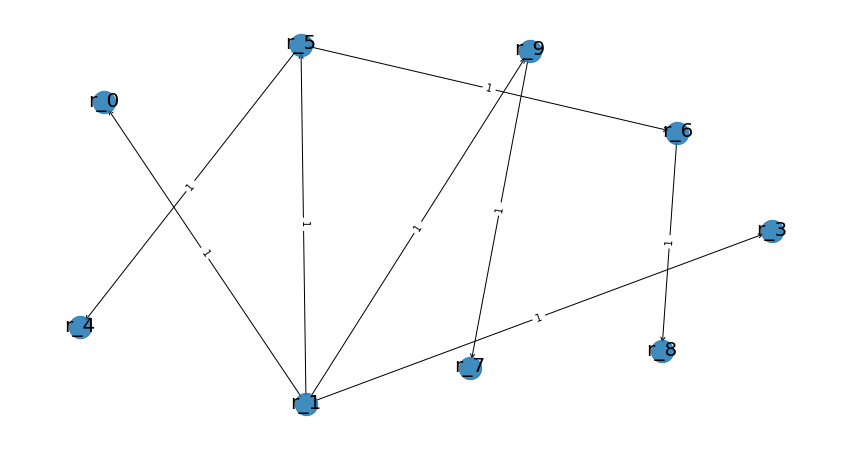

In [128]:
#### import bnlearn
import networkx as nx

%matplotlib inline
model_hc_bic  = bnlearn.structure_learning.fit(df, methodtype='hc', scoretype='bic')
G = bnlearn.plot(model_hc_bic)
plt.show()

In [129]:
G

{'pos': {'r_0': array([-0.76784095,  0.64222378]),
  'r_1': array([-0.23195809, -0.97139859]),
  'r_2': array([-0.94625139,  0.04915398]),
  'r_3': array([ 1.        , -0.04553862]),
  'r_4': array([-0.83056924, -0.56146015]),
  'r_5': array([-0.24540478,  0.95114614]),
  'r_6': array([0.75045499, 0.48081286]),
  'r_7': array([ 0.2020483 , -0.77633353]),
  'r_8': array([ 0.70967123, -0.68769389]),
  'r_9': array([0.35984993, 0.91908802])},
 'G': <networkx.classes.digraph.DiGraph at 0x2715a51a9e8>}

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [k2]
[bnlearn] >Plot based on BayesianModel


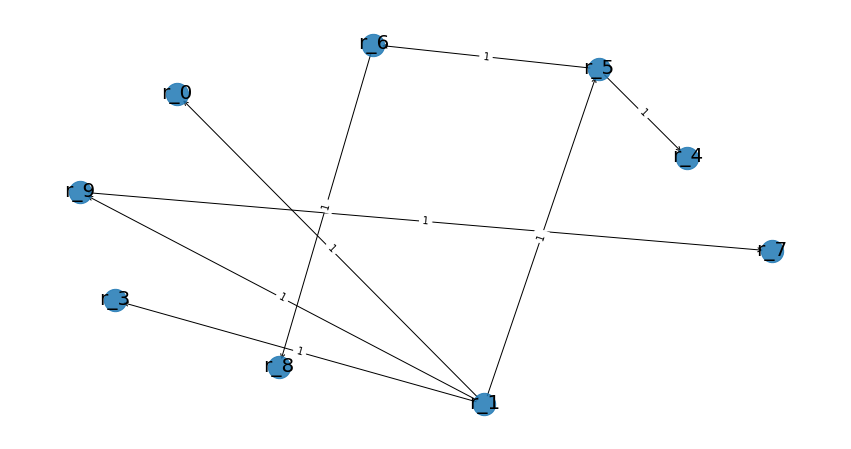

In [130]:
%matplotlib inline
model_hc_k2   = bnlearn.structure_learning.fit(df, methodtype='hc', scoretype='k2')
G = bnlearn.plot(model_hc_k2)
plt.show()

In [131]:
%matplotlib inline
model_hc_bdeu = bnlearn.structure_learning.fit(df, methodtype='hc', scoretype='bdeu')
G = bnlearn.plot(model_hc_bdeu)
plt.show()

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bdeu]
[bnlearn] >Plot based on BayesianModel
